✅ Libraries loaded

LOADING DAGSTER ASSETS
✅ Loaded: core_data
✅ Loaded: usage_info
✅ Loaded: customer_interactions
✅ Loaded: df_model_input
✅ Loaded: feature_names
✅ Loaded: logistic_regression_model
✅ Loaded: xgboost_model
✅ Loaded: X_train
✅ Loaded: X_test
✅ Loaded: y_train
✅ Loaded: y_test
✅ Loaded: scaler
✅ Loaded: evaluate_logistic_regression
✅ Loaded: evaluate_xgboost

✅ All assets loaded successfully!

MODEL INPUT DATA
Shape: (100000, 48)

Columns: ['rating_account_id', 'customer_id', 'age', 'contract_lifetime_days', 'remaining_binding_days', 'has_special_offer', 'is_magenta1_customer', 'available_gb', 'gross_mrc', 'smartphone_brand']...

First few rows:
   rating_account_id customer_id  age  contract_lifetime_days  \
0             401948    4.210872   57                     588   
1             992421    5.586489   49                    1049   
2             447254    5.280370   45                     648   
3             229501    4.146575   46                    1019   
4   

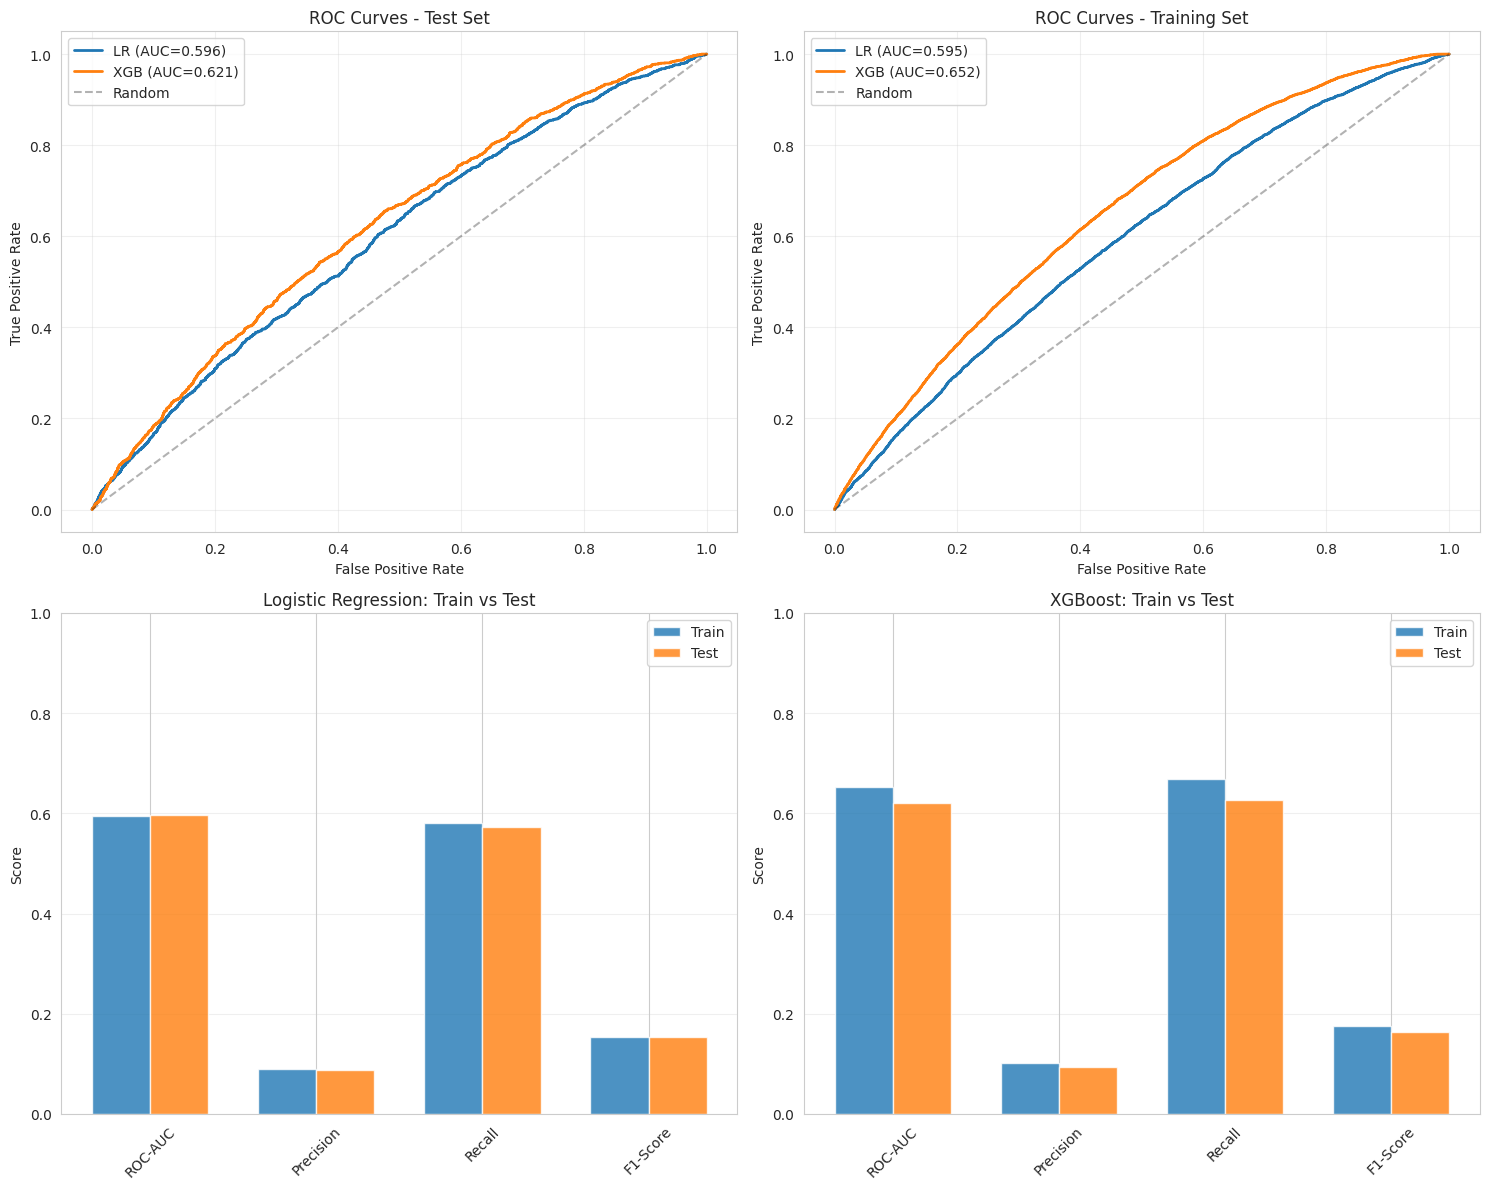

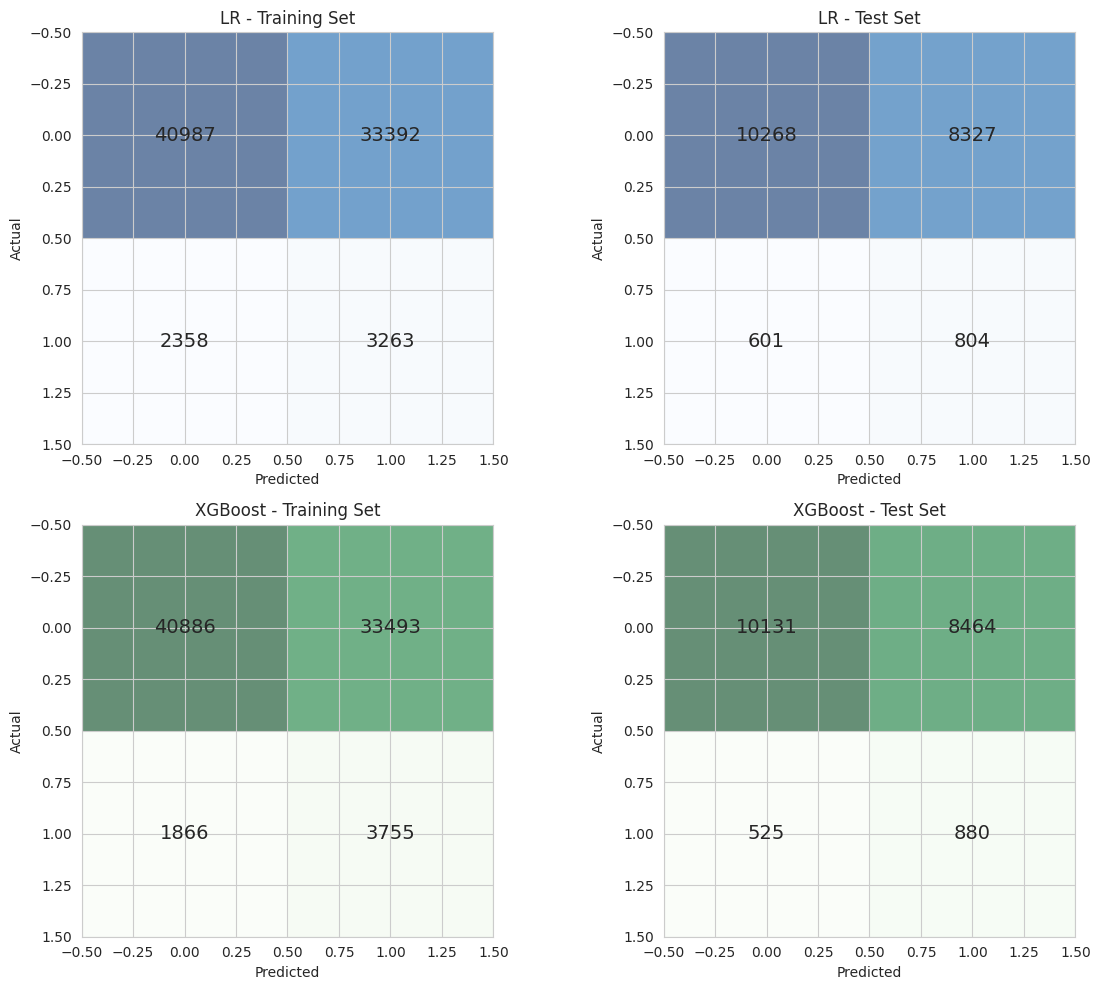

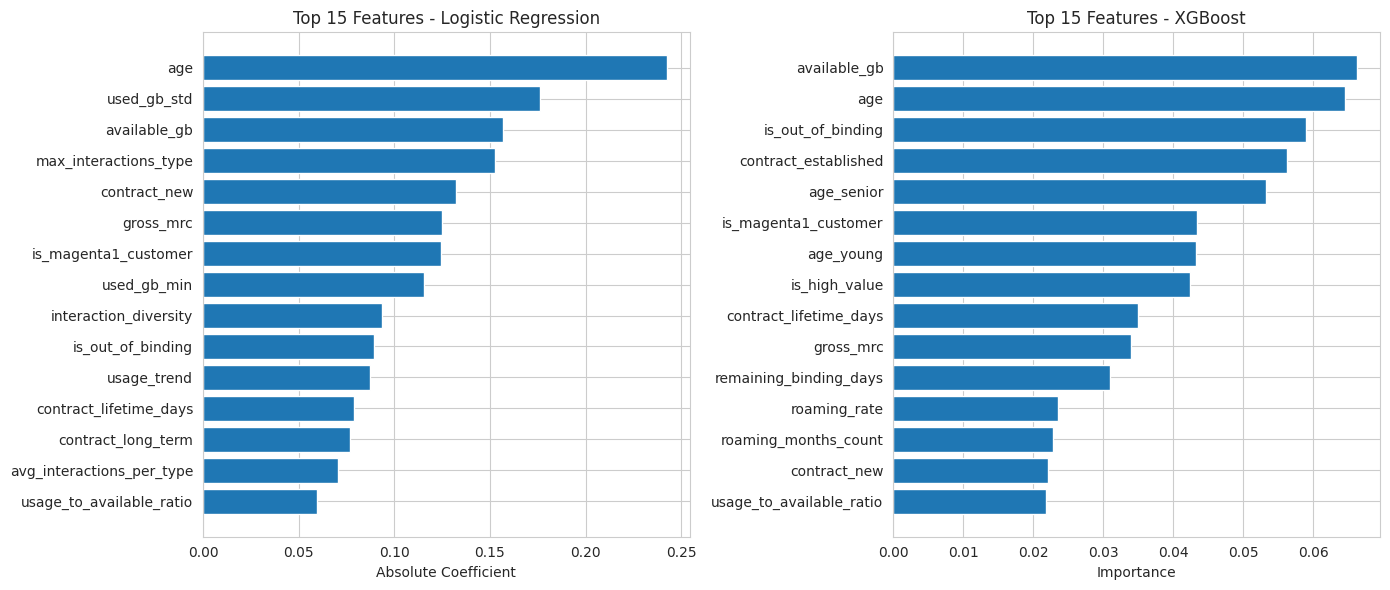


USING THE MODELS FOR PREDICTIONS

🎯 Top 10 Customers Most Likely to Upsell:
       predicted_probability  actual_upsell
86859               0.760368              0
87388               0.758060              1
93410               0.757977              0
93502               0.745295              0
90687               0.734175              0
83434               0.731051              0
59511               0.725580              1
23718               0.719002              0
80722               0.716043              0
58056               0.715348              0

📊 Distribution of Predicted Probabilities:


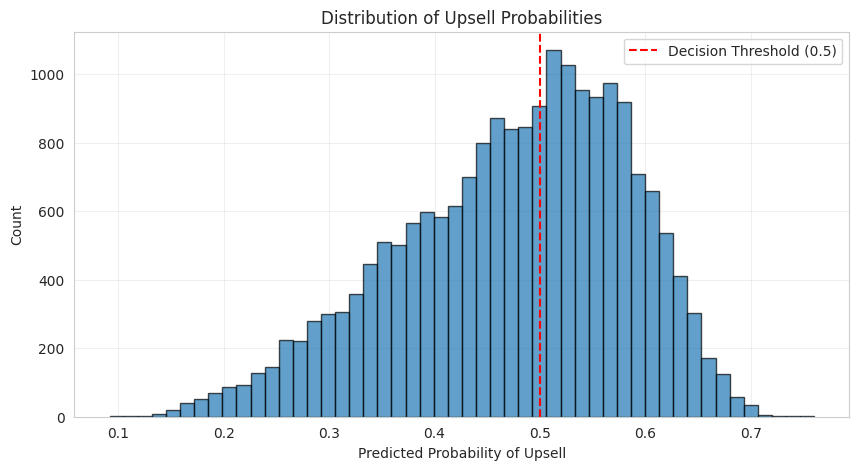


🎯 TARGETING STRATEGY:
Threshold 0.1: Target 19,999 customers, Expected conversion rate: 7.0%
Threshold 0.2: Target 19,804 customers, Expected conversion rate: 7.1%
Threshold 0.3: Target 18,467 customers, Expected conversion rate: 7.4%
Threshold 0.5: Target 9,344 customers, Expected conversion rate: 9.4%

SUMMARY
✅ Successfully loaded all Dagster-materialized assets
✅ Examined both trained models
✅ Viewed performance metrics
✅ Created visualizations
✅ Demonstrated prediction usage

💡 These are the ACTUAL models trained by your Dagster pipeline!
💡 You can now use these models for predictions or further analysis.


In [ ]:
# Load and Explore Models Trained by Dagster
# This notebook loads the actual models and data materialized by Dagster assets

import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report,
    precision_score, recall_score, f1_score, confusion_matrix
)

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("✅ Libraries loaded")

# ============================================================================
# LOAD DAGSTER MATERIALIZED ASSETS
# ============================================================================

def load_artifact(artifact_name: str, storage_dir="../tmpbo8yb74n/storage/"):
    """
    Load artifacts that were materialized by Dagster
    
    Args:
        artifact_name: Name of the asset (e.g., 'df_model_input', 'logistic_regression_model')
        storage_dir: Dagster storage directory
    """
    artifact_path = os.path.join(storage_dir, artifact_name)
    
    if not os.path.exists(artifact_path):
        print(f"❌ Asset '{artifact_name}' not found at {artifact_path}")
        print(f"📝 Make sure you've materialized this asset in Dagster UI first!")
        return None
    
    with open(artifact_path, 'rb') as fp:
        artifact = pickle.load(fp)
    
    print(f"✅ Loaded: {artifact_name}")
    return artifact

# ============================================================================
# LOAD ALL THE ASSETS YOU MATERIALIZED
# ============================================================================

print("\n" + "="*60)
print("LOADING DAGSTER ASSETS")
print("="*60)

# Load raw data
core_data = load_artifact("core_data")
usage_info = load_artifact("usage_info")
customer_interactions = load_artifact("customer_interactions")

# Load engineered features
df_model_input = load_artifact("df_model_input")
feature_names = load_artifact("feature_names")

# Load trained models
logistic_regression_model = load_artifact("logistic_regression_model")
xgboost_model = load_artifact("xgboost_model")

# Load train/test splits
X_train = load_artifact("X_train")
X_test = load_artifact("X_test")
y_train = load_artifact("y_train")
y_test = load_artifact("y_test")
scaler = load_artifact("scaler")

# Load evaluation results
evaluate_lr = load_artifact("evaluate_logistic_regression")
evaluate_xgb = load_artifact("evaluate_xgboost")

print("\n✅ All assets loaded successfully!")

# ============================================================================
# EXPLORE THE MODEL INPUT DATA
# ============================================================================

print("\n" + "="*60)
print("MODEL INPUT DATA")
print("="*60)

if df_model_input is not None:
    print(f"Shape: {df_model_input.shape}")
    print(f"\nColumns: {list(df_model_input.columns)[:10]}...")
    print(f"\nFirst few rows:")
    print(df_model_input.head())
    
    print(f"\nTarget distribution:")
    print(df_model_input['has_done_upselling'].value_counts(normalize=True))

# ============================================================================
# EXAMINE THE TRAINED MODELS
# ============================================================================

print("\n" + "="*60)
print("TRAINED MODELS")
print("="*60)

if logistic_regression_model is not None:
    lr_model = logistic_regression_model['model']
    print(f"Logistic Regression Model: {type(lr_model)}")
    print(f"Number of features: {len(lr_model.coef_[0])}")
    
    # Show top features
    print("\n📊 Top 10 Most Important Features (Logistic Regression):")
    feature_importance = logistic_regression_model['feature_importance']
    print(feature_importance.head(10))

if xgboost_model is not None:
    xgb_model = xgboost_model['model']
    print(f"\nXGBoost Model: {type(xgb_model)}")
    print(f"Number of features: {xgb_model.n_features_in_}")
    
    # Show top features
    print("\n📊 Top 10 Most Important Features (XGBoost):")
    feature_importance = xgboost_model['feature_importance']
    print(feature_importance.head(10))

# ============================================================================
# VIEW MODEL PERFORMANCE - TRAINING AND TEST SETS
# ============================================================================

print("\n" + "="*60)
print("MODEL PERFORMANCE - TRAINING VS TEST SET")
print("="*60)

# Calculate training set performance
if logistic_regression_model is not None and X_train is not None:
    lr_model = logistic_regression_model['model']
    lr_train_pred_proba = lr_model.predict_proba(X_train)[:, 1]
    lr_train_pred = lr_model.predict(X_train)
    lr_train_auc = roc_auc_score(y_train, lr_train_pred_proba) # type: ignore
    
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
    
    lr_train_precision = precision_score(y_train, lr_train_pred) # type: ignore
    lr_train_recall = recall_score(y_train, lr_train_pred) # type: ignore
    lr_train_f1 = f1_score(y_train, lr_train_pred) # type: ignore
    lr_train_cm = confusion_matrix(y_train, lr_train_pred) # type: ignore

if xgboost_model is not None and X_train is not None:
    xgb_model = xgboost_model['model']
    xgb_train_pred_proba = xgb_model.predict_proba(X_train)[:, 1]
    xgb_train_pred = xgb_model.predict(X_train)
    xgb_train_auc = roc_auc_score(y_train, xgb_train_pred_proba) # type: ignore
    
    xgb_train_precision = precision_score(y_train, xgb_train_pred) # type: ignore
    xgb_train_recall = recall_score(y_train, xgb_train_pred) # type: ignore
    xgb_train_f1 = f1_score(y_train, xgb_train_pred) # type: ignore
    xgb_train_cm = confusion_matrix(y_train, xgb_train_pred) # type: ignore

# Display results
if evaluate_lr is not None:
    print("\n" + "="*60)
    print("🔵 LOGISTIC REGRESSION PERFORMANCE")
    print("="*60)
    
    print("\n📊 TRAINING SET:")
    print(f"ROC-AUC:    {lr_train_auc:.4f}") # type: ignore
    print(f"Precision:  {lr_train_precision:.4f}") # type: ignore
    print(f"Recall:     {lr_train_recall:.4f}") # type: ignore
    print(f"F1 Score:   {lr_train_f1:.4f}") # type: ignore
    print("\nConfusion Matrix:")
    print(lr_train_cm)  # type: ignore
    
    print("\n📊 TEST SET:")
    print(f"ROC-AUC:    {evaluate_lr['roc_auc']:.4f}")
    print(f"Precision:  {evaluate_lr['confusion_matrix'][1,1] / (evaluate_lr['confusion_matrix'][1,1] + evaluate_lr['confusion_matrix'][0,1]):.4f}")
    print(f"Recall:     {evaluate_lr['confusion_matrix'][1,1] / (evaluate_lr['confusion_matrix'][1,1] + evaluate_lr['confusion_matrix'][1,0]):.4f}")
    print(f"F1 Score:   {evaluate_lr['f1_score']:.4f}")
    print("\nConfusion Matrix:")
    print(evaluate_lr['confusion_matrix'])
    
    # Check for overfitting
    auc_diff = lr_train_auc - evaluate_lr['roc_auc'] # type: ignore
    print(f"\n⚠️  Train-Test AUC Difference: {auc_diff:.4f}")
    if auc_diff > 0.05:
        print("⚠️  WARNING: Possible overfitting detected (train AUC significantly higher than test)")
    else:
        print("✅ Model generalizes well (minimal train-test gap)")

if evaluate_xgb is not None:
    print("\n" + "="*60)
    print("🟢 XGBOOST PERFORMANCE")
    print("="*60)
    
    print("\n📊 TRAINING SET:")
    print(f"ROC-AUC:    {xgb_train_auc:.4f}") # type: ignore
    print(f"Precision:  {xgb_train_precision:.4f}") # type: ignore
    print(f"Recall:     {xgb_train_recall:.4f}") # type: ignore
    print(f"F1 Score:   {xgb_train_f1:.4f}") # type: ignore
    print("\nConfusion Matrix:")
    print(xgb_train_cm) # type: ignore
    
    print("\n📊 TEST SET:")
    print(f"ROC-AUC:    {evaluate_xgb['roc_auc']:.4f}")
    print(f"Precision:  {evaluate_xgb['confusion_matrix'][1,1] / (evaluate_xgb['confusion_matrix'][1,1] + evaluate_xgb['confusion_matrix'][0,1]):.4f}")
    print(f"Recall:     {evaluate_xgb['confusion_matrix'][1,1] / (evaluate_xgb['confusion_matrix'][1,1] + evaluate_xgb['confusion_matrix'][1,0]):.4f}")
    print(f"F1 Score:   {evaluate_xgb['f1_score']:.4f}")
    print("\nConfusion Matrix:")
    print(evaluate_xgb['confusion_matrix'])
    
    # Check for overfitting
    auc_diff = xgb_train_auc - evaluate_xgb['roc_auc'] # type: ignore
    print(f"\n⚠️  Train-Test AUC Difference: {auc_diff:.4f}")
    if auc_diff > 0.05:
        print("⚠️  WARNING: Possible overfitting detected (train AUC significantly higher than test)")
    else:
        print("✅ Model generalizes well (minimal train-test gap)")

# Create comparison table
if evaluate_lr is not None and evaluate_xgb is not None:
    print("\n" + "="*60)
    print("📊 COMPLETE PERFORMANCE COMPARISON")
    print("="*60)
    
    comparison_df = pd.DataFrame({
        'LR_Train': [lr_train_auc, lr_train_precision, lr_train_recall, lr_train_f1], # type: ignore
        'LR_Test': [evaluate_lr['roc_auc'], 
                    evaluate_lr['confusion_matrix'][1,1] / (evaluate_lr['confusion_matrix'][1,1] + evaluate_lr['confusion_matrix'][0,1]),
                    evaluate_lr['confusion_matrix'][1,1] / (evaluate_lr['confusion_matrix'][1,1] + evaluate_lr['confusion_matrix'][1,0]),
                    evaluate_lr['f1_score']],
        'XGB_Train': [xgb_train_auc, xgb_train_precision, xgb_train_recall, xgb_train_f1], # type: ignore
        'XGB_Test': [evaluate_xgb['roc_auc'],
                     evaluate_xgb['confusion_matrix'][1,1] / (evaluate_xgb['confusion_matrix'][1,1] + evaluate_xgb['confusion_matrix'][0,1]),
                     evaluate_xgb['confusion_matrix'][1,1] / (evaluate_xgb['confusion_matrix'][1,1] + evaluate_xgb['confusion_matrix'][1,0]),
                     evaluate_xgb['f1_score']]
    }, index=['ROC-AUC', 'Precision', 'Recall', 'F1-Score'])
    
    print("\n")
    print(comparison_df.round(4))
    
    # Calculate train-test gaps
    print("\n📉 Train-Test Performance Gaps:")
    print(f"LR AUC Gap:   {lr_train_auc - evaluate_lr['roc_auc']:.4f}") # type: ignore
    print(f"XGB AUC Gap:  {xgb_train_auc - evaluate_xgb['roc_auc']:.4f}") # type: ignore

# ============================================================================
# VISUALIZATIONS - TRAINING VS TEST PERFORMANCE
# ============================================================================

if evaluate_lr is not None and evaluate_xgb is not None:
    print("\n📊 Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. ROC Curves - Test Set
    fpr_lr, tpr_lr, _ = roc_curve(y_test, evaluate_lr['probabilities']) # type: ignore
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, evaluate_xgb['probabilities']) # type: ignore
    
    axes[0, 0].plot(fpr_lr, tpr_lr, label=f'LR (AUC={evaluate_lr["roc_auc"]:.3f})', linewidth=2)
    axes[0, 0].plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC={evaluate_xgb["roc_auc"]:.3f})', linewidth=2)
    axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.3)
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curves - Test Set')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. ROC Curves - Training Set
    fpr_lr_train, tpr_lr_train, _ = roc_curve(y_train, lr_train_pred_proba) # type: ignore
    fpr_xgb_train, tpr_xgb_train, _ = roc_curve(y_train, xgb_train_pred_proba) # type: ignore
    
    axes[0, 1].plot(fpr_lr_train, tpr_lr_train, label=f'LR (AUC={lr_train_auc:.3f})', linewidth=2) # type: ignore
    axes[0, 1].plot(fpr_xgb_train, tpr_xgb_train, label=f'XGB (AUC={xgb_train_auc:.3f})', linewidth=2) # type: ignore
    axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.3)
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curves - Training Set')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Performance Metrics Comparison
    metrics = ['ROC-AUC', 'Precision', 'Recall', 'F1-Score']
    lr_train_metrics = [lr_train_auc, lr_train_precision, lr_train_recall, lr_train_f1] # type: ignore
    lr_test_metrics = [evaluate_lr['roc_auc'], 
                       evaluate_lr['confusion_matrix'][1,1] / (evaluate_lr['confusion_matrix'][1,1] + evaluate_lr['confusion_matrix'][0,1]),
                       evaluate_lr['confusion_matrix'][1,1] / (evaluate_lr['confusion_matrix'][1,1] + evaluate_lr['confusion_matrix'][1,0]),
                       evaluate_lr['f1_score']]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, lr_train_metrics, width, label='Train', alpha=0.8)
    axes[1, 0].bar(x + width/2, lr_test_metrics, width, label='Test', alpha=0.8)
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Logistic Regression: Train vs Test')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(metrics, rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].set_ylim([0, 1])
    
    # 4. XGBoost Performance Comparison
    xgb_train_metrics = [xgb_train_auc, xgb_train_precision, xgb_train_recall, xgb_train_f1] # type: ignore
    xgb_test_metrics = [evaluate_xgb['roc_auc'],
                        evaluate_xgb['confusion_matrix'][1,1] / (evaluate_xgb['confusion_matrix'][1,1] + evaluate_xgb['confusion_matrix'][0,1]),
                        evaluate_xgb['confusion_matrix'][1,1] / (evaluate_xgb['confusion_matrix'][1,1] + evaluate_xgb['confusion_matrix'][1,0]),
                        evaluate_xgb['f1_score']]
    
    axes[1, 1].bar(x - width/2, xgb_train_metrics, width, label='Train', alpha=0.8)
    axes[1, 1].bar(x + width/2, xgb_test_metrics, width, label='Test', alpha=0.8)
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('XGBoost: Train vs Test')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(metrics, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Confusion matrices comparison
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # LR Train
    im = axes[0, 0].imshow(lr_train_cm, cmap='Blues', alpha=0.6) # type: ignore
    axes[0, 0].set_title('LR - Training Set')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')
    for i in range(2):
        for j in range(2):
            axes[0, 0].text(j, i, lr_train_cm[i, j], ha="center", va="center", fontsize=14) # type: ignore
    
    # LR Test
    axes[0, 1].imshow(evaluate_lr['confusion_matrix'], cmap='Blues', alpha=0.6)
    axes[0, 1].set_title('LR - Test Set')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')
    for i in range(2):
        for j in range(2):
            axes[0, 1].text(j, i, evaluate_lr['confusion_matrix'][i, j], ha="center", va="center", fontsize=14)
    
    # XGB Train
    axes[1, 0].imshow(xgb_train_cm, cmap='Greens', alpha=0.6) # type: ignore
    axes[1, 0].set_title('XGBoost - Training Set')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')
    for i in range(2):
        for j in range(2):
            axes[1, 0].text(j, i, xgb_train_cm[i, j], ha="center", va="center", fontsize=14) # type: ignore
    
    # XGB Test
    axes[1, 1].imshow(evaluate_xgb['confusion_matrix'], cmap='Greens', alpha=0.6)
    axes[1, 1].set_title('XGBoost - Test Set')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')
    for i in range(2):
        for j in range(2):
            axes[1, 1].text(j, i, evaluate_xgb['confusion_matrix'][i, j], ha="center", va="center", fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance comparison
    if logistic_regression_model is not None and xgboost_model is not None:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # LR feature importance
        lr_imp = logistic_regression_model['feature_importance'].head(15)
        axes[0].barh(lr_imp['feature'], lr_imp['abs_coefficient'])
        axes[0].set_xlabel('Absolute Coefficient')
        axes[0].set_title('Top 15 Features - Logistic Regression')
        axes[0].invert_yaxis()
        
        # XGBoost feature importance
        xgb_imp = xgboost_model['feature_importance'].head(15)
        axes[1].barh(xgb_imp['feature'], xgb_imp['importance'])
        axes[1].set_xlabel('Importance')
        axes[1].set_title('Top 15 Features - XGBoost')
        axes[1].invert_yaxis()
        
        plt.tight_layout()
        plt.show()

# ============================================================================
# MAKE PREDICTIONS ON NEW DATA
# ============================================================================

print("\n" + "="*60)
print("USING THE MODELS FOR PREDICTIONS")
print("="*60)

if xgboost_model is not None and X_test is not None:
    # Get the model
    model = xgboost_model['model']
    
    # Make predictions
    predictions = model.predict_proba(X_test)[:, 1]
    
    # Create a results dataframe
    results_df = X_test.copy()
    results_df['actual_upsell'] = y_test.values # type: ignore
    results_df['predicted_probability'] = predictions
    results_df['predicted_class'] = (predictions > 0.5).astype(int)
    
    # Sort by probability (highest first) to see best targets
    results_df = results_df.sort_values('predicted_probability', ascending=False)
    
    print("\n🎯 Top 10 Customers Most Likely to Upsell:")
    print(results_df[['predicted_probability', 'actual_upsell']].head(10))
    
    print(f"\n📊 Distribution of Predicted Probabilities:")
    plt.figure(figsize=(10, 5))
    plt.hist(predictions, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Predicted Probability of Upsell')
    plt.ylabel('Count')
    plt.title('Distribution of Upsell Probabilities')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Show targeting strategy
    print("\n🎯 TARGETING STRATEGY:")
    for threshold in [0.1, 0.2, 0.3, 0.5]:
        n_targeted = (predictions >= threshold).sum()
        if n_targeted > 0:
            precision = y_test[predictions >= threshold].mean() # type: ignore
            print(f"Threshold {threshold:.1f}: Target {n_targeted:,} customers, "
                  f"Expected conversion rate: {precision:.1%}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print("✅ Successfully loaded all Dagster-materialized assets")
print("✅ Examined both trained models")
print("✅ Viewed performance metrics")
print("✅ Created visualizations")
print("✅ Demonstrated prediction usage")
print("\n💡 These are the ACTUAL models trained by your Dagster pipeline!")
print("💡 You can now use these models for predictions or further analysis.")